In [12]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [24]:
# Helper Functions
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

## Preprocess Data

In [2]:
df = pd.read_csv("Data/NHANES_Diet_Diabetes_Risk.xls.csv")
# Dropping unique IDs
#df = df.drop(columns=['MouseID'])

#Set SEQN as index
df = df.set_index("SEQN")

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6643 entries, 73557 to 83729
Columns: 168 entries, WTDRD1 to Diabetes_Risk
dtypes: float64(166), int64(2)
memory usage: 8.6 MB


,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.0,738.0,863.0,0.0,1476.0,0.0,0.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
73562,49890.82866,0.00000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.0,272.0,355.0,172.0,776.0,300.0,2339.0,2101.0,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0


In [7]:
## Split the data
X = df.drop("Diabetes_Risk", axis=1)
y = df['Diabetes_Risk'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

SEQN
73557    2
73558    2
73559    2
73561    0
73562    0
        ..
83721    0
83723    2
83724    0
83727    0
83729    0
Name: Diabetes_Risk, Length: 6643, dtype: int64

In [10]:
#Check for Null Values
X_train.isna().sum().sum()

324557

### Impute and scale the data

In [13]:
# Instantiate the imputer object from the SimpleImputer class with strategy 'median'
impute_median = SimpleImputer(strategy='median')

In [15]:
# Fit the imputer on the training data
impute_median.fit(X_train)

SimpleImputer(strategy='median')

In [21]:
# Fit the imputer on the test data
impute_median.fit(X_test)

SimpleImputer(strategy='median')

In [17]:
# Transform the training data (fill in nulls with median)
X_train_num_imputed = impute_median.transform(X_train)
X_train_num_imputed


,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,...,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78727,70710.30601,46705.128430,1.0,59.0,2.0,2.0,1.0,7.0,1.0,1.0,13.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,21.0,1339.0,50.73,211.400,77.68,15.8,34.750,11.7800,10.5150,8.7760,63.0,2.540,0.0,246.0,294.0,164.0,509.0,7.0,303.0,827.0,1.320,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
82233,60907.62017,88806.191190,1.0,25.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,3.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,12.0,858.0,45.09,105.410,16.39,5.7,27.830,9.0120,9.5540,6.5150,253.0,1.960,0.0,226.0,233.0,0.0,97.0,5.0,448.0,424.0,3.000,...,4.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0
74032,46703.93997,173276.611500,1.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,13.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,12.0,1356.0,59.90,167.900,115.17,5.2,50.450,23.2080,15.7410,4.5770,166.0,1.830,0.0,249.0,266.0,39.0,181.0,16.0,1809.0,83.0,0.567,...,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
79069,10390.35346,8097.175852,1.0,2.0,2.0,2.0,11.0,7.0,1.0,1.0,13.0,4.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,19.0,1797.0,98.61,204.130,62.15,25.1,71.020,13.1220,24.3680,25.3940,243.0,10.950,0.0,456.0,532.0,265.0,751.0,67.0,4285.0,927.0,2.665,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
77717,48746.26378,180853.851200,1.0,25.0,2.0,2.0,20.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,11.0,4299.0,138.95,559.970,299.94,27.8,174.330,65.0270,59.9960,27.5100,276.0,15.810,0.0,606.0,737.0,18.0,1509.0,21.0,31209.0,928.0,2.392,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79396,46320.68281,36097.589530,1.0,49.0,2.0,2.0,32.0,6.0,1.0,1.0,13.0,4.0,2.0,3.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,23.0,2371.0,75.70,291.400,103.13,21.0,103.120,32.7090,28.1740,32.8930,242.0,11.220,0.0,612.0,756.0,

In [22]:
# Transform the test data (fill in nulls with median)
X_test_num_imputed = impute_median.transform(X_test)
X_test_num_imputed

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,...,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
82685,65976.47854,46667.898830,1.0,54.0,2.0,2.0,22.0,6.0,1.0,1.0,13.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,8.0,1144.0,53.68,179.26,76.99,10.2,23.860,5.303,6.7580,7.7990,117.0,5.91,0.0,166.0,173.0,0.0,83.0,21.0,5.0,133.0,1.129,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
76243,12911.32997,10095.127350,1.0,49.0,2.0,2.0,10.0,6.0,1.0,1.0,13.0,4.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,19.0,2376.0,81.78,295.85,105.92,15.5,96.580,31.607,37.5670,16.8640,337.0,11.55,0.0,325.0,414.0,3.0,1069.0,6.0,27427.0,891.0,2.299,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0
78404,224183.68700,179648.842500,1.0,61.0,2.0,2.0,5.0,4.0,1.0,1.0,13.0,4.0,1.0,3.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,13.0,2601.0,76.96,396.34,60.90,37.0,79.000,16.908,26.8420,29.9720,166.0,13.49,0.0,437.0,499.0,58.0,705.0,3.0,0.0,1846.0,2.495,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
74401,59725.24271,106694.519600,1.0,59.0,2.0,2.0,8.0,5.0,1.0,1.0,13.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,2.0,549.0,25.10,58.88,40.65,1.7,24.600,7.518,8.2310,1.6700,70.0,1.97,0.0,0.0,47.0,63.0,460.0,100.0,827.0,53.0,0.103,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
81364,36256.97175,27480.797550,1.0,25.0,2.0,2.0,21.0,7.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,14.0,1776.0,101.85,200.31,71.74,13.5,66.840,16.916,23.9830,18.4110,268.0,13.03,0.0,456.0,494.0,30.0,404.0,17.0,5032.0,1482.0,1.379,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79419,41711.29073,31879.918220,1.0,61.0,2.0,2.0,34.0,3.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,91.0,18.0,1293.0,49.32,148.73,51.05,17.5,57.280,18.168,18.2570,15.7320,107.0,7.66,0.0,208.0,395.0,500.0,1997.0,5.0,26407.0,110

In [23]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf = scaler.fit_transform(X_train_num_imputed)
X_test_tf = scaler.transform(X_test_num_imputed)

## Model the Data - No PCA

In [26]:
# Import datetime library
import datetime as dt

In [32]:
%%time
# Without PCA
knn = KNeighborsClassifier()

# Now we will build the pipeline
knn.fit(X_train_tf, y_train)

CPU times: total: 15.6 ms
Wall time: 9.97 ms


KNeighborsClassifier()

In [33]:
# Record the time it takes to make predictions
%%time

preds = knn.predict(X_test_tf)



UsageError: Line magic function `%%time` not found.


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4085
           1       0.49      0.04      0.08       437
           2       0.68      0.04      0.08       460

    accuracy                           0.82      4982
   macro avg       0.66      0.36      0.35      4982
weighted avg       0.78      0.82      0.75      4982



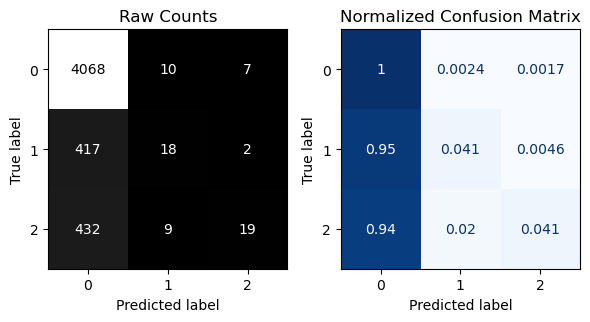


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.23      0.02      0.04       150
           2       0.30      0.02      0.04       144

    accuracy                           0.82      1661
   macro avg       0.45      0.34      0.33      1661
weighted avg       0.73      0.82      0.75      1661



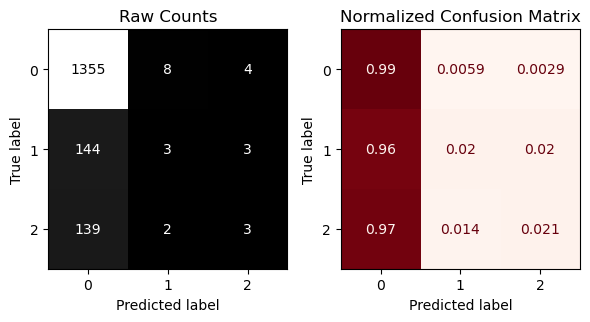

CPU times: total: 4.08 s
Wall time: 1.64 s


In [36]:
%%time
# evaluate the pipeline
evaluate_classification(knn, X_train_tf, y_train, X_test_tf, y_test)

# Transform the data with PCA​

In [37]:
# Instantiate & fit data using PCA
pca = PCA(n_components=.95)
X_train_pca = pca.fit_transform(X_train_tf)
X_test_pca = pca.transform(X_test_tf)
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69,pca70,pca71,pca72,pca73,pca74,pca75,pca76,pca77,pca78,pca79,pca80,pca81,pca82,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78727,-3.649680,0.764648,1.709007,-1.123493,-0.385363,-0.828005,-0.084729,-0.181392,0.786301,-0.028242,0.483072,-0.577797,-0.016673,0.296358,-0.245695,0.389954,0.265270,-0.383318,-0.360312,-0.102004,0.876861,0.060666,0.556837,-0.473227,0.121427,0.837177,0.140249,-0.355786,-0.110548,-0.054288,0.306467,-0.564210,0.494520,0.824716,-1.198694,-0.522387,0.200069,-0.201292,0.202897,-0.468026,-0.895188,0.025272,0.261670,0.373023,-0.017414,0.048258,-0.899927,0.770741,1.364004,0.942779,-1.194764,-0.284686,-1.325268,-1.206638,-1.305986,0.386308,0.879044,0.320764,-0.305092,-0.530911,0.018377,1.122998,-0.147931,0.332519,0.818502,-2.078847,0.459443,1.440232,-0.536239,0.147825,0.028557,-0.757080,0.267103,0.352954,0.054296,-0.432905,-0.521202,-0.026037,0.167211,-0.518424,0.610457,0.198634,0.093697,-0.127988,-0.491373,0.442518,0.074444,0.110804,-0.533148,0.415098,-0.064180,0.012142,0.278319,0.029929,0.193466,0.112053,-0.319073,0.175273,-0.181487
82233,-4.499968,2.256458,0.202801,-2.603137,0.878943,0.568911,-1.577361,-1.386312,-0.349421,-1.068728,0.165086,2.790230,-1.647374,0.682288,-0.307624,0.658101,0.331894,1.571941,-0.671523,1.124787,2.294435,-0.868414,-1.023780,0.398742,0.402738,0.871089,1.207087,1.268333,-0.748642,-0.705578,-1.580561,1.300234,1.197700,1.048102,-0.235937,-1.007016,-0.965441,0.529873,0.909837,-0.354006,1.424245,-0.128676,0.518295,-1.652049,0.347207,0.378123,0.302618,1.028287,-0.703712,-0.826548,-1.047954,0.131848,-0.789677,0.504123,-1.257322,0.863620,0.344138,-0.739061,-0.274077,1.726952,0.477055,1.062481,0.957928,-0.845496,1.770338,-0.774071,-1.336178,0.094392,1.230768,-0.663306,-0.412580,0.106383,0.193587,0.255120,-0.893460,0.207120,-0.335832,-0.802944,-0.300645,-0.201842,-0.434553,0.247906,0.074128,0.145929,-0.117604,0.089643,-0.527252,-0.263038,-0.003554,0.397013,0.243662,0.401354,0.202655,0.444708,-0.782406,0.010937,0.079925,0.128944,0.191770
74032,-3.733771,-1.710261,-0.506078,-1.630900,1.000118,-0.755961,0.428712,-1.465199,0.430562,1.163332,-0.181995,-0.152439,-0.099837,0.332131,0.461213,-0.011297,0.261248,0.168630,-0.250970,0.774875,0.272419,-0.613094,-0.730822,-0.089464,0.575228,-1.001766,0.367522,-0.089291,-0.285200,0.292518,0.009284,-0.028412,-1.268570,-0.089122,0.743117,-0.374725,0.678973,-0.059826,0.006722,-0.424081,-0.248553,-0.216375,-0.150103,-1.139156,1.223624,-0.496495,0.226410,0.069692,-0.604002,0.409108,-0.279646,-0.188078,-0.606560,-0.524039,0.947680,-0.262755,-0.325471,-0.479137,0.197324,0.585998,-0.294376,-0.304169,0.079570,-0.590416,-0.116039,-0.400827,0.441836,-0.092538,0.208473,0.204529,0.015197,0.007618,0.122733,-0.306977,0.258771,0.052687,-0.488753,0.012892,-0.295019,0.213713,0.096949,0.421228,0.378313,-0.049757,0.145764,0.231357,0.329754,0.172351,0.444590,0.188764,-0.193246,-0.193239,0.036772,-0.556546,-0.009050,-0.198828,0.207212,0.115774,0.084848
79069,-0.064294,0.613961,1.376443,1.926162,-1.452174,-0.440674,-0.373216,-0.123226,0.106464,-0.011144,0.235667,-0.314277,-0.113278,-0.534311,-0.409872,-0.208303,0.266033,-0.187316,-0.049353,-0.005145,-0.004253,0.188956,-0.108821,0.708138,0.216650,0.081670,0.152130,0.445704,0.013703,0.168780,-0.335006,-0.119654,-0.089915,0.070556,0.150356,0.230890,0.457179,0.114607,-0.764243,0.113429,-0.207924,-0.243218,-0.976036,-0.066683,0.353296,-0.936424,0.150284,-0.195649,-0.343544,0.5241

In [38]:
pca.n_components_

99

# Model - With PCA

In [40]:
# Initialize and fit PCA
pca = PCA()
pca_data = pca.fit(X_train_tf, y_train)


In [41]:
knn.fit(X_train_pca, y_train)

KNeighborsClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4085
           1       0.50      0.05      0.09       437
           2       0.68      0.04      0.08       460

    accuracy                           0.82      4982
   macro avg       0.67      0.36      0.36      4982
weighted avg       0.79      0.82      0.76      4982



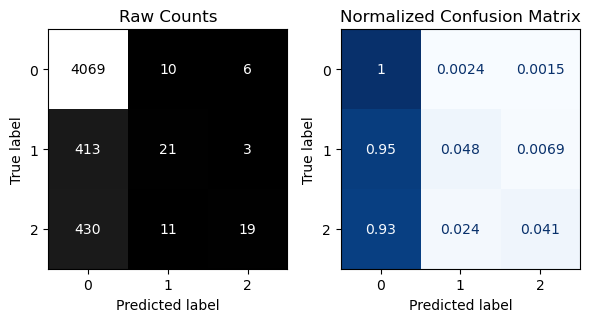


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1367
           1       0.43      0.02      0.04       150
           2       0.29      0.01      0.03       144

    accuracy                           0.82      1661
   macro avg       0.51      0.34      0.32      1661
weighted avg       0.74      0.82      0.75      1661



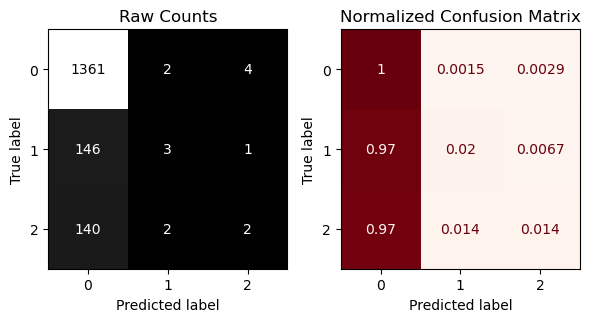

CPU times: total: 3.92 s
Wall time: 1.57 s


In [44]:
%%time
#Evaluate the Model

evaluate_classification(knn, X_train_pca,y_train, X_test_pca, y_test)

# Compare the Models

Q1. How many features were used in the first model, and how many PCs were used in the PCA model? The first model used 166 features. The PCA model used 99 features.
Q2. Which model performed the best on the test set The models performed about the same.?
Q3. Which model was the fastest at making prediction The PCA model was slightly faster than the first model.s?